# Notebook 03: ELM Options Pricing Framework

This notebook demonstrates the complete ELM-based options pricing framework. We'll cover:

1. **OptionPricingELM Class** - Main ELM pricing interface
2. **Data Generation** - Synthetic option data creation
3. **Training Process** - ELM model training with various configurations
4. **Prediction and Evaluation** - Pricing options and measuring accuracy
5. **Analytical Comparison** - Comparing ELM prices with analytical methods
6. **Hyperparameter Optimization** - Finding optimal ELM parameters

## Key Features

- **Fast Training**: ELM trains in milliseconds
- **High Accuracy**: Competitive with analytical methods
- **Flexible Architecture**: Multiple activation functions and configurations
- **Comprehensive Evaluation**: Built-in comparison with analytical methods


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Import our ELM pricing implementation
import sys
sys.path.append('../src')

from elm.models.pricing.elm_pricer import OptionPricingELM, generate_heston_training_data, create_train_val_test_split
from elm.data.loader import load_training_data

# Set random seed for reproducibility
np.random.seed(42)


In [2]:
# 1. Data Generation and Loading


# Option 1: Load existing cached data (if available)
try:
    print("   Attempting to load cached training data...")
    X, y = load_training_data(n_samples=10000, cache_dir="../data/")
    print(f"Loaded cached data: X={X.shape}, y={y.shape}")
except:
    print("   Cache not found, generating new data...")
    # Option 2: Generate new synthetic data
    X, y = generate_heston_training_data(
        n_samples=10000,
        option_type="call",
        random_state=42
    )
    print(f"Generated new data: X={X.shape}, y={y.shape}")

# Display feature information
feature_names = ["S0", "K", "T", "r", "q", "v0", "theta", "kappa", "sigma", "rho"]
print(f"\nFeature Information:")
print(f"   Features: {feature_names}")
print(f"   Sample ranges:")
for i, name in enumerate(feature_names):
    print(f"     {name}: [{X[:, i].min():.3f}, {X[:, i].max():.3f}]")

print(f"\nTarget Information:")
print(f"   Option prices range: [{y.min():.4f}, {y.max():.4f}]")
print(f"   Mean option price: {y.mean():.4f}")
print(f"   Std option price: {y.std():.4f}")

# Split data
X_train, X_val, X_test, y_train, y_val, y_test = create_train_val_test_split(
    X, y, random_state=42, val_size=0.0, test_size=0.2, train_size=0.8
)

print(f"\nData Split:")
print(f"   Training: {X_train.shape[0]} samples")
print(f"   Validation: {X_val.shape[0]} samples") 
print(f"   Test: {X_test.shape[0]} samples")


   Attempting to load cached training data...
Loading cached training data from ../data...
Loaded X: (10000, 10), y: (10000,)
Loaded cached data: X=(10000, 10), y=(10000,)

Feature Information:
   Features: ['S0', 'K', 'T', 'r', 'q', 'v0', 'theta', 'kappa', 'sigma', 'rho']
   Sample ranges:
     S0: [80.000, 119.989]
     K: [80.006, 119.997]
     T: [0.100, 3.000]
     r: [0.000, 0.050]
     q: [0.000, 0.000]
     v0: [0.010, 0.450]
     theta: [0.010, 0.090]
     kappa: [0.101, 4.000]
     sigma: [0.100, 0.400]
     rho: [-1.000, -0.100]

Target Information:
   Option prices range: [0.0627, 0.8846]
   Mean option price: 0.5111
   Std option price: 0.1356

Data Split:
   Training: 8000 samples
   Validation: 0 samples
   Test: 2000 samples


ELM model created with 3000 hidden neurons
   Training in progress...
   Training completed in 0.5968 seconds
   Training speed: 13404 samples/second
 Making predictions...

 Performance Metrics:
   RMSE: 0.002098
   MAE:  0.000842
   MAPE: 0.27%


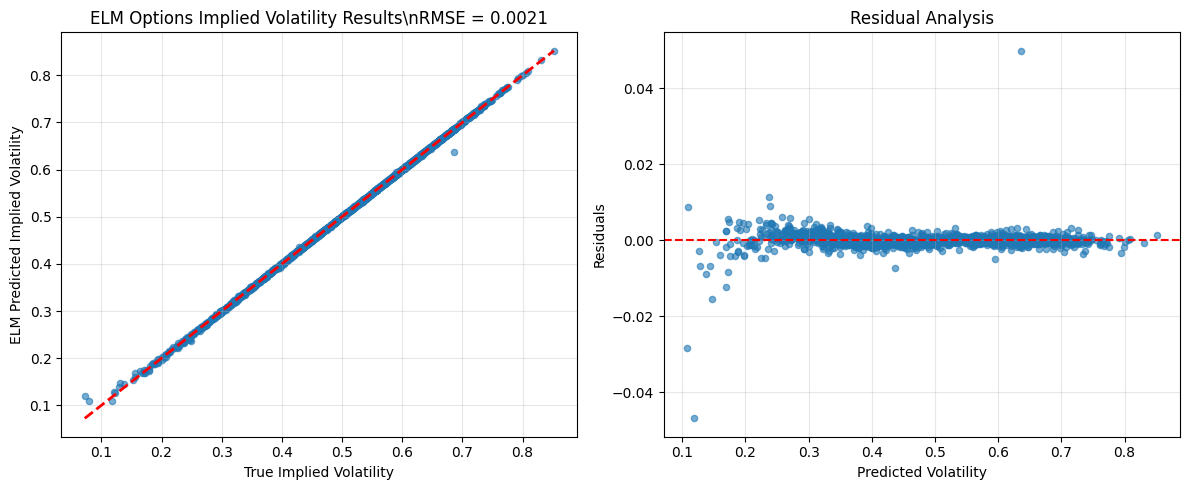

In [3]:
# 2. ELM Model Training

# Create ELM pricer with optimized parameters
elm_pricer = OptionPricingELM(
    n_hidden=3000,              # Large network for high accuracy
    activation="sine",          # Sine activation often works well for finance
    scale=0.5,                  # Smaller scale for sine activation
    random_state=42,
    normalise_features=True,    # Normalize input features
    normalise_target=False,     # Keep target prices as-is
    regularisation_param=1e-3,  # Strong regularization
    clip_negative=False,        # Allow negative prices for some transforms
    target_transform="none",    # No target transformation
    forward_normalise=True,     # Normalize by forward price
    normalised_init=True        # Normalized weight initialization
)

print(f"ELM model created with {elm_pricer.n_hidden} hidden neurons")

# Train the model
print("   Training in progress...")
start_time = time.time()
elm_pricer.fit(X_train, y_train)
training_time = time.time() - start_time

print(f"   Training completed in {training_time:.4f} seconds")
print(f"   Training speed: {len(X_train)/training_time:.0f} samples/second")

# Make predictions on test set
print(" Making predictions...")
y_pred = elm_pricer.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"\n Performance Metrics:")
print(f"   RMSE: {rmse:.6f}")
print(f"   MAE:  {mae:.6f}")
print(f"   MAPE: {mape:.2f}%")

# Plot results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Implied Volatility')
plt.ylabel('ELM Predicted Implied Volatility')
plt.title(f'ELM Options Implied Volatility Results\\nRMSE = {rmse:.4f}')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Volatility')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Comparing ELM predictions with analytical methods...
   Comparing on 100 test samples...

ELM vs Analytical (COS Method) Comparison:
   Correlation: 0.999969
   RMSE: 0.001113
   MAE:  0.000746


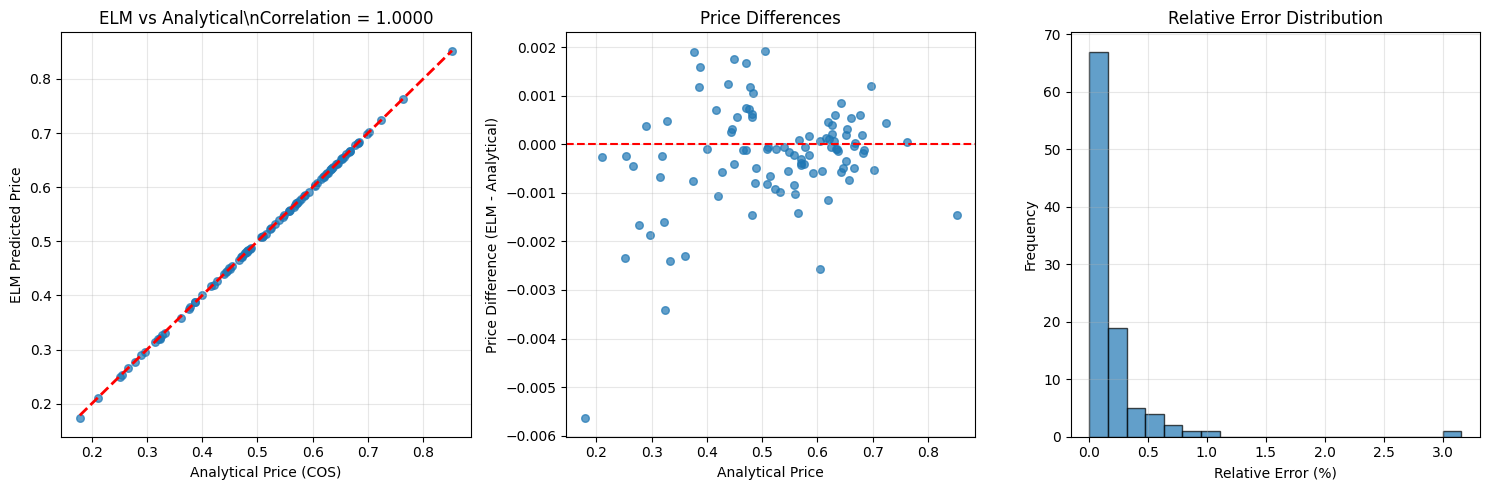


 Error Analysis:
   Mean absolute relative error: 0.19%
   Median absolute relative error: 0.10%
   95th percentile error: 0.63%
   Max relative error: 3.16%


In [4]:
# 3. Analytical Comparison

print("Comparing ELM predictions with analytical methods...")

# Compare with analytical methods on a subset for speed
n_comparison = min(100, len(X_test))  # Compare on 100 samples
X_compare = X_test[:n_comparison]
y_true_compare = y_test[:n_comparison]

print(f"   Comparing on {n_comparison} test samples...")

# Get ELM predictions
elm_prices = elm_pricer.predict(X_compare, )

# Compare with analytical methods
elm_prices_analytical, analytical_prices = elm_pricer.compare_with_analytical(
    X_compare, method="cos",
    comparison_mode="implied_volatility"
)

# Calculate comparison metrics
correlation = np.corrcoef(elm_prices, analytical_prices)[0, 1]
rmse_analytical = np.sqrt(mean_squared_error(analytical_prices, elm_prices))
mae_analytical = mean_absolute_error(analytical_prices, elm_prices)

print(f"\nELM vs Analytical (COS Method) Comparison:")
print(f"   Correlation: {correlation:.6f}")
print(f"   RMSE: {rmse_analytical:.6f}")
print(f"   MAE:  {mae_analytical:.6f}")

# Plot comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(analytical_prices, elm_prices, alpha=0.7, s=30)
plt.plot([analytical_prices.min(), analytical_prices.max()], 
         [analytical_prices.min(), analytical_prices.max()], 'r--', lw=2)
plt.xlabel('Analytical Price (COS)')
plt.ylabel('ELM Predicted Price')
plt.title(f'ELM vs Analytical\\nCorrelation = {correlation:.4f}')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
price_diff = elm_prices - analytical_prices
plt.scatter(analytical_prices, price_diff, alpha=0.7, s=30)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Analytical Price')
plt.ylabel('Price Difference (ELM - Analytical)')
plt.title('Price Differences')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
relative_error = np.abs(price_diff / analytical_prices) * 100
plt.hist(relative_error, bins=20, alpha=0.7, edgecolor='black')
plt.xlabel('Relative Error (%)')
plt.ylabel('Frequency')
plt.title('Relative Error Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n Error Analysis:")
print(f"   Mean absolute relative error: {np.mean(relative_error):.2f}%")
print(f"   Median absolute relative error: {np.median(relative_error):.2f}%")
print(f"   95th percentile error: {np.percentile(relative_error, 95):.2f}%")
print(f"   Max relative error: {np.max(relative_error):.2f}%")
